# **In-Class Assignment: Annotation, POS Tagging & Syntax Parsing**
## *IS 5150*
## Name: Key

I wanted to cover this during the NLP pipeline, but we ran out of time. This topic is related to annotation is in a sense, another form of feature engineering or metadata creation, in that we're extracting information from raw text to induce more meaning from the text -- but it's not feature engineering in that we're not quantifying the text.

Instead, we're applying some useful labels to the text that speak to its structure. This can be helpful in a number of different text mining tasks, including semantic analysis and named entity recognition (among others). 

In this in-class assignment, we'll use some pretrained annotation models to apply part-of-speech tags to text, as well as to apply different types of syntactic parsing schemes to the text. We will also develop our own deterministic POS tagging model and compare it against pretrained ones.

To begin, let's import `nltk`, `spacy`, `graphviz`, `pydot_ng`, `pandas`, and `os`. You may also need to install some software called *GhostScript*, but we'll see...

In [ ]:
import nltk
#nltk.download('all', halt_on_error = False)

import spacy
spacy.load('en_core_web_sm')

import graphviz
import pydot_ng
!pip install svgling
import svgling

import pandas as pd
import os

[Install GhostScript Windows](https://ghostscript.en.uptodown.com/windows/download)


[Install GhostScript Mac OSX](https://macappstore.org/ghostscript/)

In [ ]:
# for windows users: set the path to your ghostcript bin folder from program files
os.environ['PATH'] = os.environ['Path']+";C:\Program Files\gs\gs9.56.1" # run if using jupyter notebooks/lab

## **POS Tagging with Spacy**

First, let's try out a pretrained POS tagging model from Spacy (the en_core_web_sm model). We will apply it to an example news sentence, since this model was trained on a corpus of WSJ articles (as is the next one).

In [ ]:
sentence = "US unveils world's most powerful supercomputer, beats China."

nlp = spacy.load('en_core_web_sm')

In [ ]:
sentence_nlp = nlp(sentence) #tokenize sentence

spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns = ['Word', 'POS Tag', 'Tag type']).T

,0,1,2,3,4,5,6,7,8,9,10
Word,US,unveils,world,'s,most,powerful,supercomputer,",",beats,China,.
POS Tag,NNP,VBZ,NN,POS,RBS,JJ,NN,",",VBZ,NNP,.
Tag type,PROPN,VERB,NOUN,PART,ADV,ADJ,NOUN,PUNCT,VERB,PROPN,PUNCT


In [ ]:
spacy.explain("PART")

'particle'

## **POS Tagging with NLTK**

Now let's try out the POS tagging model from `nltk` and examine whether there are any differences:

In [ ]:
nltk_pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
pd.DataFrame(nltk_pos_tagged, columns = ['Word', 'Pos Tag']).T

,0,1,2,3,4,5,6,7,8,9,10
Word,US,unveils,world,'s,most,powerful,supercomputer,",",beats,China,.
Pos Tag,NNP,JJ,NN,POS,RBS,JJ,NN,",",VBZ,NNP,.


**Are there any differences between the Spacy and NLTK pos taggers? Why could this occur?**

## **Building our own POS tagger**

To understand why there are different POS tags applied to the same sentence based on different models, it would be helpful to see how POS taggers can be constructed. We'll try out a few different methods, including both deterministic (i.e., rule-based) and learning based approaches:

Let's establish a baseline `accuracy` for our taggers; which would be just be applying a 'default tag' (most common class) to all words. We want to achieve higher accuracy in the taggers we produce.

Our first step is to bring in the `treebank` POS tagged setences from `nltk`, we will use a portion of these sentences as 'training data' to construct our taggers, and the remaning sentences as a 'test set' to evaluate its accuracy.

In [ ]:
nltk.download('treebank')
from nltk.corpus import treebank

data = treebank.tagged_sents()
len(data)

In [ ]:
train_data = data[:3500]
test_data = data[3500:]
print(train_data[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


#### **Default tagging - baseline majority class tagger**

In [ ]:
from nltk.tag import DefaultTagger
dt = DefaultTagger('NN') #will tag all words in the test set as nouns

dt.evaluate(test_data)

0.1454158195372253

In [ ]:
dt.tag(nltk.word_tokenize(sentence))

[('US', 'NN'),
 ('unveils', 'NN'),
 ('world', 'NN'),
 ("'s", 'NN'),
 ('most', 'NN'),
 ('powerful', 'NN'),
 ('supercomputer', 'NN'),
 (',', 'NN'),
 ('beats', 'NN'),
 ('China', 'NN'),
 ('.', 'NN')]

**What can we ascertain from this default tagging method?**

#### **Deterministic POS Taggin with Regex**

See, I told you regex would keep coming up. In our first attempt of creating a better than baseline POS tagger, let's use some regex patterns to write a rule-set for POS tagging:

**What are some common suffixes we could use to try and identify POS?**

In [ ]:
from nltk.tag import RegexpTagger

patterns = [
    (r'.*ing$', 'VBG'),              # gerunds
    (r'.*ed$', 'VBD'),               # simple past tense
    (r'.*es$', 'VBZ'),               # 3rd singular present
    (r'.*ould$', 'MD'),              # modals
    (r'.*\'s$', 'NN$'),              # possessive nouns
    (r'.*s$', 'NNS'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), # cardinal numbers
    (r'.*', 'NN')                    # nouns (default)
]

rt = RegexpTagger(patterns)

rt.accuracy(test_data)

0.24039113176493368

In [ ]:
rt.tag(nltk.word_tokenize(sentence))

[('US', 'NN'),
 ('unveils', 'NNS'),
 ('world', 'NN'),
 ("'s", 'NN$'),
 ('most', 'NN'),
 ('powerful', 'NN'),
 ('supercomputer', 'NN'),
 (',', 'NN'),
 ('beats', 'NNS'),
 ('China', 'NN'),
 ('.', 'NN')]

**What are some issues our regex pattern based tokenizer encountered?**

### **Learning Based Approaches**

#### **N gram Taggers**

This first learning approach identies common unigrams (one word) and bigrams (two word pairs) and tries to learn their POS tags from the labeled training data. Then it tries to predict the POS tag based on the unigram and bigrams in the test set.

Let's try it out:

In [ ]:
from nltk.tag import UnigramTagger
from nltk.tag import BigramTagger

nltk.download('punkt')

ut = UnigramTagger(train_data) # train the unigram tagger on the training data
bt = BigramTagger(train_data)  # train the unigram tagger on the training data

In [ ]:
print(ut.accuracy(test_data))
print(ut.tag(nltk.word_tokenize(sentence)))

0.8607803272340013
[('US', 'NNP'), ('unveils', None), ('world', 'NN'), ("'s", 'POS'), ('most', 'JJS'), ('powerful', 'JJ'), ('supercomputer', 'NN'), (',', ','), ('beats', None), ('China', 'NNP'), ('.', '.')]


**This learning based method certainly outperforms the previous deterministic approaches, but still tags some words incorrectly as 'None'. Why might this happen in a learning based method when it didn't occur when using the less accurate deterministic methods?**

In [ ]:
print(bt.accuracy(test_data))
print(bt.tag(nltk.word_tokenize(sentence)))

0.13466937748087907
[('US', None), ('unveils', None), ('world', None), ("'s", None), ('most', None), ('powerful', None), ('supercomputer', None), (',', None), ('beats', None), ('China', None), ('.', None)]


**Based on what we just discussed, why might the bigram tagger have performed significantly worse than the unigram tagger?**

**We can get the best of both worlds using a combined tagging model, it will first search for matching bigrams, then matching unigrams, then apply our regex rules if there are no learned matches:**

In [ ]:
def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff

ct = combined_tagger(train_data = train_data, taggers = [UnigramTagger, BigramTagger],
                     backoff=rt) #uses regex as the backup

print(ct.accuracy(test_data))
print(ct.tag(nltk.word_tokenize(sentence)))

0.9103495014038145
[('US', 'NNP'), ('unveils', 'NNS'), ('world', 'NN'), ("'s", 'POS'), ('most', 'RBS'), ('powerful', 'JJ'), ('supercomputer', 'NN'), (',', ','), ('beats', 'NNS'), ('China', 'NNP'), ('.', '.')]


**Why might the POS tagger mark 'unveils' as NNS - plural noun?**

### **Naive Bayes Classifier**
Beyond just training a tagger on the tags of individual words or bi-grams, the `nltk NaiveBayesClassifier` trains the algorithm on additional features like word, previous word, tag, previous tag, case, etc.

It's okay if you're not familiar with Naive Bayes, we will cover classification methods in more detail during Unit 2. For now, know that it is a method of supervised learning designed to learn and then predict class labels, like POS tags.

In [ ]:
from nltk.classify import NaiveBayesClassifier, MaxentClassifier
from nltk.tag.sequential import ClassifierBasedPOSTagger

nbt = ClassifierBasedPOSTagger(train = train_data,
                              classifier_builder=NaiveBayesClassifier.train) # train using supervised learning algorithm


print(nbt.evaluate(test_data))
print(nbt.tag(nltk.word_tokenize(sentence)))

0.9306806079969019
[('US', 'PRP'), ('unveils', 'VBZ'), ('world', 'VBN'), ("'s", 'POS'), ('most', 'JJS'), ('powerful', 'JJ'), ('supercomputer', 'NN'), (',', ','), ('beats', 'VBZ'), ('China', 'NNP'), ('.', '.')]


In [ ]:
10/11 # what's the accuracy on our sample sentence?

0.9090909090909091

**Here we see a slight drop in performance on our example sentence, but overall still high accuracy. How might we expect this same POS tagger to perform on literature? Tweets?**

# **Syntax Parsing**

We won't train our own syntax parsers because they're more complicated than POS taggers; dealing with classifying different levels of sentence structures, instead of just classifying word classes. 

However, we will take a look at some pretrained parsers for performing Dependency and Constituency parsing.

#### **Dependency Parsing with Spacy**

In [ ]:
sentence = "The fox jumped over the fence and the cow went moo."
sentence_nlp = nlp(sentence)

dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n---------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_,
                                   w_type=token.dep_,
                                   left=[t.orth_
                                        for t 
                                        in token.lefts],
                                   right=[t.orth_
                                         for t in
                                         token.rights]))

[]<---The[det]--->[]
---------
['The']<---fox[nsubj]--->[]
---------
['fox']<---jumped[ROOT]--->['over', 'and', 'went']
---------
[]<---over[prep]--->['fence']
---------
[]<---the[det]--->[]
---------
['the']<---fence[pobj]--->[]
---------
[]<---and[cc]--->[]
---------
[]<---the[det]--->[]
---------
['the']<---cow[nsubj]--->[]
---------
['cow']<---went[conj]--->['moo', '.']
---------
[]<---moo[acomp]--->[]
---------
[]<---.[punct]--->[]
---------


In [ ]:
from spacy import displacy

displacy.render(sentence_nlp, jupyter = True,
               options={'distance': 110,
                       'arrow_stroke': 2,
                       'arrow_width': 8})

**What is the root of the sentence? How do you know? Why should we care about the root and its dependencies?**

#### **Constituency Parsing with nltk**

Now let's try out constuency parsing, which is a bit more involved to implement.

**How is constituency parsing different from dependency parsing?**

In [ ]:
from nltk import Nonterminal
from nltk.corpus import treebank

In [ ]:
training_set = treebank.parsed_sents()
print(training_set[1])

(S
  (NP-SBJ (NNP Mr.) (NNP Vinken))
  (VP
    (VBZ is)
    (NP-PRD
      (NP (NN chairman))
      (PP
        (IN of)
        (NP
          (NP (NNP Elsevier) (NNP N.V.))
          (, ,)
          (NP (DT the) (NNP Dutch) (VBG publishing) (NN group))))))
  (. .))


**What does this mean in English? Let's break it down...**

We have a simple clause where the highest order phrase is the subject noun phrase; *Mr. Vinken* is our subject; this is followed by a verb phrase which is attached to our subject, and specifies its relation to the next noun phrase, which tells us what Mr. Vinken is -- *a chairman* -- followed by a prepositional phrase to indicate what he is the chairman of -- *Elsevier N.V., the Dutch publishing group*.

In [ ]:
# extract production rules (grammar rules) for all annotated sentences from nltk treebank 

treebank_productions = list(
                        set(production
                           for sent in training_set
                           for production in sent.productions()
                           )
                        )

treebank_productions[0:10]

[NN -> 'book',
 JJ -> '54-year-old',
 NNP -> 'Woolworth',
 VP -> ADVP-MNR VBN NP PP-CLR,
 VB -> 'recruit',
 NP-SBJ-47 -> PRP$ JJ NN,
 VB -> 'tuck',
 NNP -> 'Army',
 CD -> '325,000',
 NNS -> 'suitors']

In [ ]:
tokens = nltk.word_tokenize(sentence)
#nltk.download('averaged_perceptron_tagger')

tagged_sent = nltk.pos_tag(nltk.word_tokenize(sentence))
print(tagged_sent)

[('The', 'DT'), ('fox', 'NN'), ('jumped', 'VBD'), ('over', 'IN'), ('the', 'DT'), ('fence', 'NN'), ('and', 'CC'), ('the', 'DT'), ('cow', 'NN'), ('went', 'VBD'), ('moo', 'NN'), ('.', '.')]


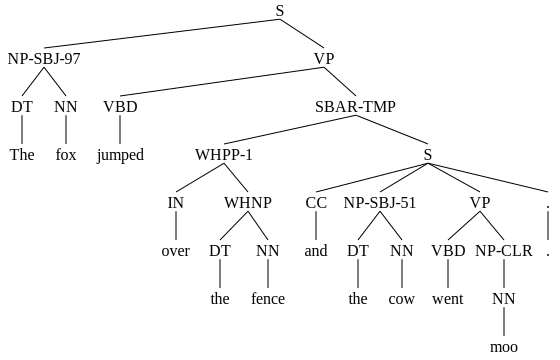

In [ ]:
for word, tag in tagged_sent:
    t = nltk.Tree.fromstring("("+ tag +" "+ word +")")
    for production in t.productions():
        treebank_productions.append(production)
        
        
treebank_grammar = nltk.grammar.induce_pcfg(Nonterminal('S'), treebank_productions)

viterbi_parser = nltk.ViterbiParser(treebank_grammar)
result = list(viterbi_parser.parse(tokens))[0]

result

[Penn Treebank Constituency Tags](http://surdeanu.cs.arizona.edu/mihai/teaching/ista555-fall13/readings/PennTreebankConstituents.html)

**How does the Constituency Parse tree differ from the Depedency parse graph in its representation of the sentence "The fox jumped over the fence and the cow went moo."?**